In [106]:
%matplotlib inline
from pathlib import Path
import pickle
from PIL import Image
import io
import gdown
import zipfile

import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import argparse

# define seed
manualSeed = 999
print(f"Seed: {manualSeed}")
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Seed: 999


### Load Data

In [107]:
# training imgs download url + output file name definition
url = 'https://drive.google.com/uc?id=1A423Vi62SWb3FHtwieXDlmtIEcQHb2ub'
outfile = "imgs.zip"

# download imgs if imgs folder does not exist
if not os.path.exists("imgs"):
    gdown.download(url, outfile, quiet=False)

    with zipfile.ZipFile(outfile, 'r') as zip_ref:
        zip_ref.extractall()
    os.remove("imgs.zip")

### Globals

In [108]:
cwd = os.getcwd() # collect current working directory
dataroot = Path(f"{cwd}/imgs") # define data directory
workers = 2 # number of workers for dataloader
batch_size = 128 # batch size during training (64 + 64)
num_channels = 3 # number of channels in the training images. For color images this is 3 (RGB)
image_size = 64 # also the size of feature maps for the generator and discriminator
z_size = 100 # size of z latent vector (i.e. size of generator input)
num_epochs = 100 # number of training epochs
# num_epochs = 400 # number of training epochs
lr = 0.0002 # learning rate for optimizers
num_gpu = 2 # number of GPUs available. Use 0 for CPU mode.

### Define Transforms, Loaders, and preview Data

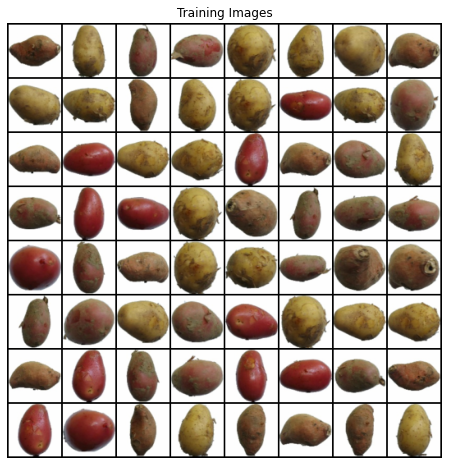

In [109]:
# define transform
tfs = transforms.Compose([transforms.Resize(image_size),
                          transforms.CenterCrop(image_size),
                          transforms.ToTensor(),
                          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])

# define the dataset
dataset = dset.ImageFolder(root=dataroot,transform=tfs)

# define the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# define available device
device = torch.device("cuda:0" if (torch.cuda.is_available() and num_gpu > 0) else "cpu")

# plot training image grid
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

### Build GAN

From the DCGAN paper, the authors specify that all model weights shall be randomly initialized from a Normal distribution with `mean=0, stdev=0.02`. The weights_init function provided by PyTorch takes an initialized model as input and reinitialize all convolutional, convolutional-transpose, and batch normalization layers to meet this criteria. This function should be applied to the models immediately after initialization.

In [110]:
# custom weights initialization for netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

The generator, G, is designed to map the latent space vector (z) to data-space. Since our data are images, converting z to data-space means ultimately creating a RGB image with the same size as the training images (3x64x64). In practice, this is accomplished through a series of strided two dimensional convolutional transpose layers, each paired with a 2d batch norm layer and a relu activation. The output of the generator is fed through a tanh function to return it to the input data range of `[-1,1]`. It is worth noting the existence of the batch norm functions after the conv-transpose layers, as this is a critical contribution of the DCGAN paper. These layers help with the flow of gradients during training. 

Notice, how the inputs we set in the input section (z_size, image_size, and num_channels) influence the generator architecture in code. z_size is the length of the z input vector, image_size relates to the size of the feature maps that are propagated through the generator, and num_channels is the number of channels in the output image (set to 3 for RGB images). Below is the code for the generator.

### Generator

For the Generator class we will implement a sequential network with transpose convolutions (upsampling) also known as a fractionally-strided convolution;
in PyTorch the module is called ConvTranspose2d and can be seen as the gradient of Conv2d where we are traditionally downsampling.

Between each layer we will place a batch normalization function, calculating the mean and standard-deviation per-dimension over mini-batches.
This method is used for accelerating the training in deep networks by reducing internal covariate shift.
Also between each layer we will place a ReLU function for expressing our neurons; 

Finally we use Tanh for our probabilistic output.

In [111]:
'''
#### ReLu(x) ####
ReLu(x) = max(0, x)
Properties = non-linear unbounded, negative value suppression, helps overcome vanishing gradient, expressive neurons

# Function
if x < 0 ==> 0
if x >= 0 ==> x

# Gradient
if x <= 0 ==> 0
if x > 0 ==> 1

#### Tanh(x) ####
Tanh(x) = (e^x - e^(-x)) / (e^x + e^(-x))
Properties = [-1,1]; asymptotic, probabilistic

# The Quotient Rule
(a/b)' = (a'b - ab') / b^2

# Gradient
((e^x - e^(-x)) / (e^x + e^(-x)))' = 1 - (Tanh(x))^2
                                   = 1 - Tanh(x) * Tanh(x) # actual implementation because compute
'''

"\n#### ReLu(x) ####\nReLu(x) = max(0, x)\nProperties = non-linear unbounded, negative value suppression, helps overcome vanishing gradient, expressive neurons\n\n# Function\nif x < 0 ==> 0\nif x >= 0 ==> x\n\n# Gradient\nif x <= 0 ==> 0\nif x > 0 ==> 1\n\n#### Tanh(x) ####\nTanh(x) = (e^x - e^(-x)) / (e^x + e^(-x))\nProperties = [-1,1]; asymptotic, probabilistic\n\n# The Quotient Rule\n(a/b)' = (a'b - ab') / b^2\n\n# Gradient\n((e^x - e^(-x)) / (e^x + e^(-x)))' = 1 - (Tanh(x))^2\n                                   = 1 - Tanh(x) * Tanh(x) # actual implementation because compute\n"

In [112]:
class Generator(nn.Module):
    def __init__(self, num_gpu):
        super(Generator, self).__init__()

        self.num_gpu = num_gpu
        self.trainImgs = []
        self.losses = []
        
        tconv1 = image_size * 8 # 64 x 8 = 512 channels
        tconv2 = image_size * 4 # 64 x 4 = 256 channels
        tconv3 = image_size * 2 # 64 x 2 = 128 channels
        
        self.main = nn.Sequential(
            # input Z = 100 x 1 
            nn.ConvTranspose2d(in_channels = z_size, # 100
                               out_channels = tconv1, # 64 x 8 = 512 channels
                               kernel_size = 4, 
                               stride = 1, 
                               padding = 0, 
                               bias=False),
            nn.BatchNorm2d(tconv1),
            nn.ReLU(True),
            # feature_size = 64 / 2^4 = 64 / 16 = 4 ==> 4 x 4
            # feature_channels = 512 x 2 = 1024
            # transpose_state = 4 x 4 (1024 channels)

            nn.ConvTranspose2d(in_channels = tconv1, # 64 x 8 = 512 channels
                               out_channels = tconv2, # 64 x 4 = 256 channels
                               kernel_size = 4, 
                               stride = 2, 
                               padding = 1,
                               bias=False),
            nn.BatchNorm2d(tconv2),
            nn.ReLU(True),
            # feature_size = 64 / 2^3 = 64 / 8 = 8 ==> 8 x 8
            # feature_channels = 256 x 2 = 512
            # transpose_state = 8 x 8 (512 channels)

            nn.ConvTranspose2d(in_channels = tconv2, # 64 x 4 = 256 channels
                               out_channels = tconv3, # 64 x 2 = 128 channels
                               kernel_size = 4, 
                               stride = 2, 
                               padding = 1,
                               bias=False),
            nn.BatchNorm2d(tconv3),
            nn.ReLU(True),
            # feature_size = 64 / 2^2 = 64 / 4 = 16 ==> 16 x 16
            # feature_channels = 128 x 2 = 256
            # transpose_state = 16 x 16 (256 channels)

            nn.ConvTranspose2d(in_channels = tconv3, # 64 x 2 = 128 channels
                               out_channels = image_size, # 64 x 64 = 3 channels
                               kernel_size = 4, 
                               stride = 2, 
                               padding = 1,
                               bias=False),
            nn.BatchNorm2d(image_size),
            nn.ReLU(True),
            # feature_size = 64 / 2^1 = 64 / 2 = 32 ==> 32 x 32
            # feature_channels = 64 x 2 = 128
            # transpose_state = 32 x 32 (128 channels)

            nn.ConvTranspose2d(in_channels = image_size,
                               out_channels = num_channels, 
                               kernel_size = 4, 
                               stride = 2, 
                               padding = 1, 
                               bias=False),
            nn.Tanh()
            # output = 64 x 64 (3 channels)
        )

    def forward(self, input):
        return self.main(input)

In [113]:
# init generator
netG = Generator(num_gpu).to(device)

# handle multi-gpu if needed
if (device.type == 'cuda') and (num_gpu > 1):
    netG = nn.DataParallel(netG, [0])

# randomly initialize all weights to mean=0, stdev=0.2
netG.apply(weights_init)

# display model structure
print(netG)

DataParallel(
  (module): Generator(
    (main): Sequential(
      (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU(inplace=True)
      (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2

### Discriminator

For the Discriminator class we will implement a MLP network to train against our Generator.

Between each layer we will place a LeakyReLu function for expressing our neurons and utilize dropout (0.2); This essentially simulates training large numbers of architectures simultaneously. 
Importantly, dropout can drastically reduce the chance of overfitting during training. 

Finally, we use Sigmoid for our probabilistic output.

In [114]:
''' 
#### LeakyReLu(x) ####
LeakyReLu(x) = max(alpha * x, x)
Properties = non-linear unbounded, negative alpha mask, more expressive neurons

# Function
if x < 0 ==> alpha * x
if x >= 0 ==> x

# Gradient
if x < 0 ==> alpha
if x >= 0 ==> 1

#### Sigmoid(x) ####
Sigmoid(x) = e^x / (1 + e^x)
Properties = [0,1]; asymptotic, probabilistic

# The Quotient Rule
(a/b)' = (a'b - ab') / b^2

# Gradient
(e^x / (1 + e^x))' = S(x) * 1 / (1 + e^x)

# since
1 / (1 + e^x) = 1 - S(x)

(e^x / (1 + e^x))' = S(x) * (1 - S(x))
'''

" \n#### LeakyReLu(x) ####\nLeakyReLu(x) = max(alpha * x, x)\nProperties = non-linear unbounded, negative alpha mask, more expressive neurons\n\n# Function\nif x < 0 ==> alpha * x\nif x >= 0 ==> x\n\n# Gradient\nif x < 0 ==> alpha\nif x >= 0 ==> 1\n\n#### Sigmoid(x) ####\nSigmoid(x) = e^x / (1 + e^x)\nProperties = [0,1]; asymptotic, probabilistic\n\n# The Quotient Rule\n(a/b)' = (a'b - ab') / b^2\n\n# Gradient\n(e^x / (1 + e^x))' = S(x) * 1 / (1 + e^x)\n\n# since\n1 / (1 + e^x) = 1 - S(x)\n\n(e^x / (1 + e^x))' = S(x) * (1 - S(x))\n"

In [115]:
class Discriminator(nn.Module):
    def __init__(self, num_gpu):
        super(Discriminator, self).__init__()

        self.num_gpu = num_gpu
        self.losses = []

        conv1 = image_size * 2 # 64 x 2 = 128 channels
        conv2 = image_size * 4 # 64 x 4 = 256 channels
        conv3 = image_size * 8 # 64 x 8 = 512 channels

        self.main = nn.Sequential(
            # input = 64 x 64 (3 channels)
            nn.Conv2d(in_channels = num_channels, # 3
                      out_channels = image_size, # 64
                      kernel_size = 4,
                      stride = 2,
                      padding = 1,
                      bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # feature_size = 64 / 2^1 = 64 / 2 = 32 ==> 32 x 32
            # feature_channels = 64 x 2 = 128
            # conv_state = 32 x 32 (128 channels)

            nn.Conv2d(in_channels = image_size, # 64
                      out_channels = conv1, # 64 x 2 = 128 channels
                      kernel_size = 4,
                      stride = 2,
                      padding = 1,
                      bias=False),
            nn.BatchNorm2d(conv1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.2),
            # feature_size = 64 / 2^2 = 64 / 4 = 16 ==> 16 x 16
            # feature_channels = 128 x 2 = 256
            # conv_state = 16 x 16 (256 channels)

            nn.Conv2d(in_channels = conv1, # 64 x 2 = 128 channels
                      out_channels = conv2, # 64 x 4 = 256 channels
                      kernel_size = 4, 
                      stride = 2,
                      padding = 1,
                      bias=False),
            nn.BatchNorm2d(conv2),
            nn.LeakyReLU(0.2, inplace=True),
            # feature_size = 64 / 2^3 = 64 / 8 = 8 ==> 8 x 8
            # feature_channels = 256 x 2 = 512
            # transpose_state = 8 x 8 (512 channels)

            nn.Conv2d(in_channels = conv2, # 64 x 4 = 256 channels
                      out_channels = conv3, # 64 x 8 = 512 channels
                      kernel_size = 4,
                      stride = 2,
                      padding = 1,
                      bias=False),
            nn.BatchNorm2d(conv3),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.2),
            # feature_size = 64 / 2^4 = 64 / 16 = 4 ==> 4 x 4
            # feature_channels = 512 x 2 = 1024
            # transpose_state = 4 x 4 (1024 channels)

            nn.Conv2d(in_channels = conv3, # 64 x 8 = 512 channels
                      out_channels = 1,
                      kernel_size = 4,
                      stride = 1,
                      padding = 0,
                      bias=False),
            nn.Sigmoid()
            # output = 100 x 1
        )

    def forward(self, input):
        return self.main(input)

In [116]:
# init discriminator
netD = Discriminator(num_gpu).to(device)

# handle multi-gpu if needed
if (device.type == 'cuda') and (num_gpu > 1):
    netD = nn.DataParallel(netD, [0])

# randomly initialize all weights to mean=0, stdev=0.2
netD.apply(weights_init)

# display model structure
print(netD)

DataParallel(
  (module): Discriminator(
    (main): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): LeakyReLU(negative_slope=0.2, inplace=True)
      (5): Dropout2d(p=0.2, inplace=False)
      (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): LeakyReLU(negative_slope=0.2, inplace=True)
      (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): LeakyReLU(negative_slope=0.2, inplace=True)
      (12): Dropout2d(p=0.2, inpla

In [117]:
class Results():
    '''define object for network results storage'''
    def __init__(self):
        self.trainImgs = []
        self.gLosses = []
        self.dLosses = []

### Training

The proposed training framework corresponds to a two-player minimax game (v_i=max_a_i min_a_-i(v_i(a_i,a_-i)). In the space of arbitrary functions G and D, a unique solution exists, with G recovering the training data distribution and D equal to 1/2 everywhere. In the case where G and D are defined by multilayer perceptrons, the entire system can be trained with backpropagation.

Training order of operations is as follows
* Train Discriminator by attempting to maximize log(D(x)) + log(1 - D(G(z)))
    * train on real batch
    * train on fake batch
* Update Generator by attempting to maximize log(D(G(z)))

In [118]:
def trainGAN():
    random.seed(123)

    # init criterion
    criterion = nn.BCELoss()

    # create batch of latent vectors that we will use to visualize
    # the progression of the generator
    fixed_noise = torch.randn(image_size, z_size, 1, 1, device=device)

    # establish convention for real and fake labels during training
    # giving bias to the labels makes sure the network is not as sure
    real_label = 1.-0.3+random.random()*0.5 # 0.7~1.2 (i.e close to 1)
    fake_label = random.random()*0.3 # (i.e close to 0 but not less than)

    # define optimizers for both G and D
    optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

    # init results object
    results = Results()
    iters = 0

    print("Starting Training Loop...")
    # for each epoch
    for epoch in range(num_epochs):
        # for each batch in the dataloader
        for i, data in enumerate(dataloader,0):

            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            netD.zero_grad()
            # format batch
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            # forward pass real batch through D
            output = netD(real_cpu).view(-1)
            # calculate loss on all-real batch
            errD_real = criterion(output, label)
            # calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            ## Train with all-fake batch
            # generate batch of latent vectors
            noise = torch.randn(b_size, z_size, 1, 1, device=device)
            # generate fake image batch with G
            fake = netG(noise)
            label.fill_(fake_label)
            # classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            optimizerD.step() # update D

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            label.fill_(real_label) # fake labels are real for generator cost
            # since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)
            # calculate G's loss based on this output
            errG = criterion(output, label)
            # calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item() 
            optimizerG.step() # update G

            # output training stats
            if i % 50 == 0:
                # [0/100][0/24]	Loss_D: 1.0707	Loss_G: 6.3156	D(x): 0.7842	D(G(z)): 0.2768 / 0.0004
                # [1/100][0/24]	Loss_D: 1.6666	Loss_G: 1.8993	D(x): 0.1658	D(G(z)): 0.0346 / 0.1087
                # [2/100][0/24]	Loss_D: 1.3123	Loss_G: 1.4161	D(x): 0.2583	D(G(z)): 0.0395 / 0.2240
                # [3/100][0/24]	Loss_D: 1.0458	Loss_G: 2.6512	D(x): 0.7249	D(G(z)): 0.2751 / 0.0363
                print(f'[{epoch:d}/{num_epochs:d}][{i:d}/{len(dataloader):d}] Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f} D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')

            # store losses in results object
            results.gLosses.append(errG.item())
            results.dLosses.append(errD.item())

            # save generated (fake) output for visualization
            if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
                with torch.no_grad():
                    fake = netG(fixed_noise).detach().cpu() # generate fake images
                results.trainImgs.append(vutils.make_grid(fake, padding=2, normalize=True)) # add images to results object

            iters += 1
    return results

In [119]:
# define model and result paths
model_dir = Path('models')
g_path = os.path.join(model_dir,'potato_g.pkl')
d_path = os.path.join(model_dir,'potato_d.pkl')
r_path = os.path.join(model_dir,'results.pkl')

# train if either G or D is missing
if not os.path.exists(g_path) or not os.path.exists(d_path):
    results = trainGAN()

In [120]:
# save pickle file for both models and result objects, if file does not exist
if not os.path.exists(g_path):
    g_file = open(g_path, 'wb')
    pickle.dump(netG, g_file)
    g_file.close()

if not os.path.exists(d_path):
    g_file = open(d_path, 'wb')
    pickle.dump(netG, g_file)
    g_file.close()

if not os.path.exists(r_path):
    r_file = open(r_path, 'wb')
    pickle.dump(results, r_file)
    r_file.close()

# delete pickle files and re-run notebook to save new model and result objects

In [121]:
# define class to unpickle on current device (CPU or GPU), independent of which device the model was trained on.
class DeviceUnpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location=device)
        else: return super().find_class(module, name)

In [122]:
# load pickle file for each model
g_file = open(g_path, 'rb')
newNetG = DeviceUnpickler(g_file).load()
g_file.close()

d_file = open(d_path, 'rb')
newNetD = DeviceUnpickler(d_file).load()
d_file.close()

r_file = open(r_path, 'rb')
newResults = pickle.Unpickler(r_file).load()
r_file.close()

# send both models to CPU if no GPU is available
if not torch.cuda.is_available():
    newNetG = newNetG.module.to(device)
    newNetD = newNetD.module.to(device)

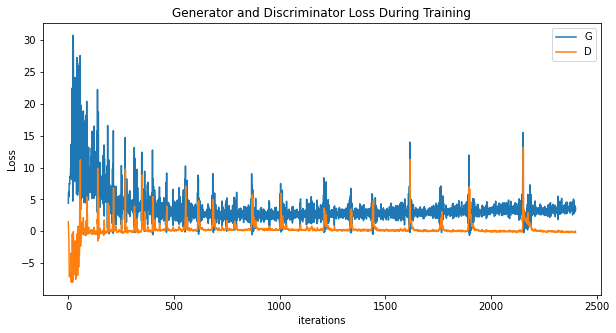

In [123]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(newResults.gLosses,label="G")
plt.plot(newResults.dLosses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

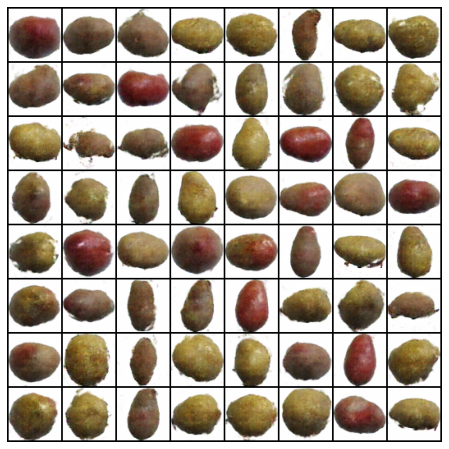

In [124]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in newResults.trainImgs[0:10]]
ani = animation.ArtistAnimation(fig, ims, interval=100, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [125]:
def random_tater(model):
    '''generate 64 random fake images with given model then select the 0th item'''
    noise = torch.randn(64, 100, 1, 1, device=device)
    fakes = model(noise).detach().cpu()
    fake_img = fakes[0]
    grid = vutils.make_grid(fake_img, padding=2, normalize=True)
    return transforms.ToPILImage()(grid)

In [126]:
tater = random_tater(newNetG)
tater.show()